In [1]:
import os
import cv2
import random
import shutil
import pathlib
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from shutil import copyfile
import tensorflow_hub as hub
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import drive
from google.colab import files

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

In [3]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
source_path = '/content/drive/MyDrive/Data/dataset/'
source_path_lima_asli = os.path.join(source_path, 'uang50asli')
source_path_seratus_asli = os.path.join(source_path, 'uang100asli')
source_path_lima_palsu = os.path.join(source_path, 'uang50palsu')
source_path_seratus_palsu = os.path.join(source_path, 'uang100palsu')

In [6]:
# Fungsi untuk membuat folder

def createFolder(root_path):

  print(f"Creating \'{root_path}\' directory.")
  os.makedirs(root_path)

  seratus_asli_path = os.path.join(root_path, 'uang100asli')
  os.makedirs(seratus_asli_path)
  print(f"\nUang 100 Asli directory created as \'{seratus_asli_path}\'.")

  seratus_palsu_path = os.path.join(root_path, 'uang100palsu')
  os.makedirs(seratus_palsu_path)
  print(f"\nUang 100 Palsu directory created as \'{seratus_palsu_path}\'.")

  lima_asli_path = os.path.join(root_path, 'uang50asli')
  os.makedirs(lima_asli_path)
  print(f"\nUang 50 Asli directory created as \'{lima_asli_path}\'.")

  lima_palsu_path = os.path.join(root_path, 'uang50palsu')
  os.makedirs(lima_palsu_path)
  print(f"\nUang 50 Palsu directory created as \'{lima_palsu_path}\'.")

In [7]:
root_dir = '/content/data'
# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  createFolder(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/data' directory.

Uang 100 Asli directory created as '/content/data/uang100asli'.

Uang 100 Palsu directory created as '/content/data/uang100palsu'.

Uang 50 Asli directory created as '/content/data/uang50asli'.

Uang 50 Palsu directory created as '/content/data/uang50palsu'.


In [8]:
def importData(source, destination):
   files = []
   for filename in os.listdir(source):
    file = source + filename
        
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
    
    for filename in files:
      this_file = source + filename
      destination_path = destination + filename
      copyfile(this_file, destination_path)

In [9]:
source_100_asli = '/content/drive/MyDrive/Data/dataset/uang100asli/'
source_100_palsu = '/content/drive/MyDrive/Data/dataset/uang100palsu/'
source_50_asli = '/content/drive/MyDrive/Data/dataset/uang50asli/'
source_50_palsu = '/content/drive/MyDrive/Data/dataset/uang50palsu/'

destination_100_asli = '/content/data/uang100asli/'
destination_100_palsu = '/content/data/uang100palsu/'
destination_50_asli = '/content/data/uang50asli/'
destination_50_palsu = '/content/data/uang50palsu/'

In [10]:
importData(source_100_asli, destination_100_asli)
importData(source_100_palsu, destination_100_palsu)
importData(source_50_asli, destination_50_asli)
importData(source_50_palsu, destination_50_palsu)

In [11]:
def imageAugmentation(source):
  files = []
  for filename in os.listdir(source):
    file = source + filename
        
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  num = len(files) + 1
  images = glob(source+'*')

  for path in images:
    img = Image.open(path)
    img = img.resize((224,224))
    mirimg = img.transpose(Image.FLIP_LEFT_RIGHT)
    mirimg.save(source+str(num)+'.jpg')
    num+=1
    # lrotimg = img.rotate(90, Image.NEAREST, expand = 1)
    # lrotimg.save(source+str(num)+'.jpg')
    # num+=1=

In [12]:
imageAugmentation(destination_100_asli)
imageAugmentation(destination_100_palsu)
imageAugmentation(destination_50_asli)
imageAugmentation(destination_50_palsu)

In [13]:
# Fungsi untuk membuat folder training, validation, testing

def create_train_test_dirs(root_path):

  print(f"Creating \'{root_path}\' directory.")
  os.makedirs(root_path)

  training_dir = os.path.join(root_path, 'training')
  os.makedirs(training_dir)
  print(f"\nTraining directory created as \'{training_dir}\'.")

  validation_dir = os.path.join(root_path, 'validation')
  os.makedirs(validation_dir)
  print(f"\nValidation directory created as \'{validation_dir}\'.")

  testing_dir = os.path.join(root_path, 'testing')
  os.makedirs(testing_dir)
  print(f"\nTesting directory created as \'{testing_dir}\'.")

  print("\nCreating the subfolders for storing fake and real money images.")
  
  training_real_lima_dir = os.path.join(training_dir, "money50real")
  training_real_seratus_dir = os.path.join(training_dir, "money100real")
  training_fake_lima_dir = os.path.join(training_dir, "money50fake")
  training_fake_seratus_dir = os.path.join(training_dir, "money100fake")
  os.makedirs(training_real_lima_dir)
  os.makedirs(training_real_seratus_dir)
  os.makedirs(training_fake_lima_dir)
  os.makedirs(training_fake_seratus_dir)
  print(f"\'{training_real_lima_dir}\' and \'{training_real_seratus_dir}\' created.")
  print(f"\'{training_fake_lima_dir}\' and \'{training_fake_seratus_dir}\' created.")

  validation_real_lima_dir = os.path.join(validation_dir, "money50real")
  validation_real_seratus_dir = os.path.join(validation_dir, "money100real")
  validation_fake_lima_dir = os.path.join(validation_dir, "money50fake")
  validation_fake_seratus_dir = os.path.join(validation_dir, "money100fake")
  os.makedirs(validation_real_lima_dir)
  os.makedirs(validation_real_seratus_dir)
  os.makedirs(validation_fake_lima_dir)
  os.makedirs(validation_fake_seratus_dir)
  print(f"\'{validation_real_lima_dir}\' and \'{validation_real_seratus_dir}\' created.")
  print(f"\'{validation_fake_lima_dir}\' and \'{validation_fake_seratus_dir}\' created.")

  testing_real_lima_dir = os.path.join(testing_dir, "money50real")
  testing_real_seratus_dir = os.path.join(testing_dir, "money100real")
  testing_fake_lima_dir = os.path.join(testing_dir, "money50fake")
  testing_fake_seratus_dir = os.path.join(testing_dir, "money100fake")
  os.makedirs(testing_real_lima_dir)
  os.makedirs(testing_real_seratus_dir)
  os.makedirs(testing_fake_lima_dir)
  os.makedirs(testing_fake_seratus_dir)
  print(f"\'{testing_real_lima_dir}\' and \'{testing_real_seratus_dir}\' created.")
  print(f"\'{testing_fake_lima_dir}\' and \'{testing_fake_seratus_dir}\' created.")

In [14]:
# Init directory root_dir
root_dir = '/content/real-v-fake'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/real-v-fake' directory.

Training directory created as '/content/real-v-fake/training'.

Validation directory created as '/content/real-v-fake/validation'.

Testing directory created as '/content/real-v-fake/testing'.

Creating the subfolders for storing fake and real money images.
'/content/real-v-fake/training/money50real' and '/content/real-v-fake/training/money100real' created.
'/content/real-v-fake/training/money50fake' and '/content/real-v-fake/training/money100fake' created.
'/content/real-v-fake/validation/money50real' and '/content/real-v-fake/validation/money100real' created.
'/content/real-v-fake/validation/money50fake' and '/content/real-v-fake/validation/money100fake' created.
'/content/real-v-fake/testing/money50real' and '/content/real-v-fake/testing/money100real' created.
'/content/real-v-fake/testing/money50fake' and '/content/real-v-fake/testing/money100fake' created.


# MOBILENETV2 - FULL - 60:20:20

In [15]:
# Splitting files into training, testing, validation

def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
        
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  validation_length_dep = int(len(files) - training_length)
  validation_length = int(validation_length_dep/2)
  testing_length = int(len(files) - validation_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  validation_set = shuffled_set[-validation_length_dep:-validation_length]
  testing_set = shuffled_set[testing_length:]
    
  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)
  
  for filename in validation_set:
    this_file = SOURCE + filename
    destination = VALIDATION + filename
    copyfile(this_file, destination)
        
  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

In [16]:
REAL_LIMA_SOURCE_DIR = '/content/data/uang50asli/'
FAKE_LIMA_SOURCE_DIR = '/content/data/uang50palsu/'
REAL_SERATUS_SOURCE_DIR = '/content/data/uang100asli/'
FAKE_SERATUS_SOURCE_DIR = '/content/data/uang100palsu/'

TRAINING_DIR = "/content/real-v-fake/training/"
VALIDATION_DIR = "/content/real-v-fake/validation/"
TESTING_DIR = "/content/real-v-fake/testing/"

In [17]:
# Define directories path

TRAINING_REAL_LIMA_DIR = os.path.join(TRAINING_DIR, "money50real/")
VALIDATION_REAL_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50real/")
TESTING_REAL_LIMA_DIR = os.path.join(TESTING_DIR, "money50real/")

TRAINING_REAL_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100real/")
VALIDATION_REAL_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100real/")
TESTING_REAL_SERATUS_DIR = os.path.join(TESTING_DIR, "money100real/")

TRAINING_FAKE_LIMA_DIR = os.path.join(TRAINING_DIR, "money50fake/")
VALIDATION_FAKE_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50fake/")
TESTING_FAKE_LIMA_DIR = os.path.join(TESTING_DIR, "money50fake/")

TRAINING_FAKE_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100fake/")
VALIDATION_FAKE_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100fake/")
TESTING_FAKE_SERATUS_DIR = os.path.join(TESTING_DIR, "money100fake/")

In [18]:
# Run split data function

# Define proportion of images used for training
split_size = .6

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(TESTING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_SERATUS_DIR):
    os.remove(file.path)

In [19]:
split_data(REAL_LIMA_SOURCE_DIR, TRAINING_REAL_LIMA_DIR, VALIDATION_REAL_LIMA_DIR, TESTING_REAL_LIMA_DIR, split_size)
split_data(REAL_SERATUS_SOURCE_DIR, TRAINING_REAL_SERATUS_DIR, VALIDATION_REAL_SERATUS_DIR, TESTING_REAL_SERATUS_DIR, split_size)
split_data(FAKE_LIMA_SOURCE_DIR, TRAINING_FAKE_LIMA_DIR, VALIDATION_FAKE_LIMA_DIR, TESTING_FAKE_LIMA_DIR, split_size)
split_data(FAKE_SERATUS_SOURCE_DIR, TRAINING_FAKE_SERATUS_DIR, VALIDATION_FAKE_SERATUS_DIR, TESTING_FAKE_SERATUS_DIR, split_size)

In [20]:
# Train Images
print("===Training Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TRAINING_REAL_LIMA_DIR)), len(os.listdir(TRAINING_REAL_SERATUS_DIR)), len(os.listdir(TRAINING_FAKE_LIMA_DIR)), len(os.listdir(TRAINING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Training Images Dataset===



,Total Images
50.000 Asli,576
100.000 Asli,576
50.000 Palsu,336
100.000 Palsu,336


In [21]:
# Testing Images
print("===Testing Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TESTING_REAL_LIMA_DIR)), len(os.listdir(TESTING_REAL_SERATUS_DIR)), len(os.listdir(TESTING_FAKE_LIMA_DIR)), len(os.listdir(TESTING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Testing Images Dataset===



,Total Images
50.000 Asli,192
100.000 Asli,192
50.000 Palsu,112
100.000 Palsu,112


In [22]:
# Validation Images
print("===Validation Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(VALIDATION_REAL_LIMA_DIR)), len(os.listdir(VALIDATION_REAL_SERATUS_DIR)), len(os.listdir(VALIDATION_FAKE_LIMA_DIR)), len(os.listdir(VALIDATION_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Validation Images Dataset===



,Total Images
50.000 Asli,192
100.000 Asli,192
50.000 Palsu,112
100.000 Palsu,112


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/content/real-v-fake/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testing': <SplitInfo num_examples=608, num_shards=1>,
        'training': <SplitInfo num_examples=1824, num_shards=1>,
        'validation': <SplitInfo num_examples=608, num_shards=1>,
    },
    citation="""""",
)


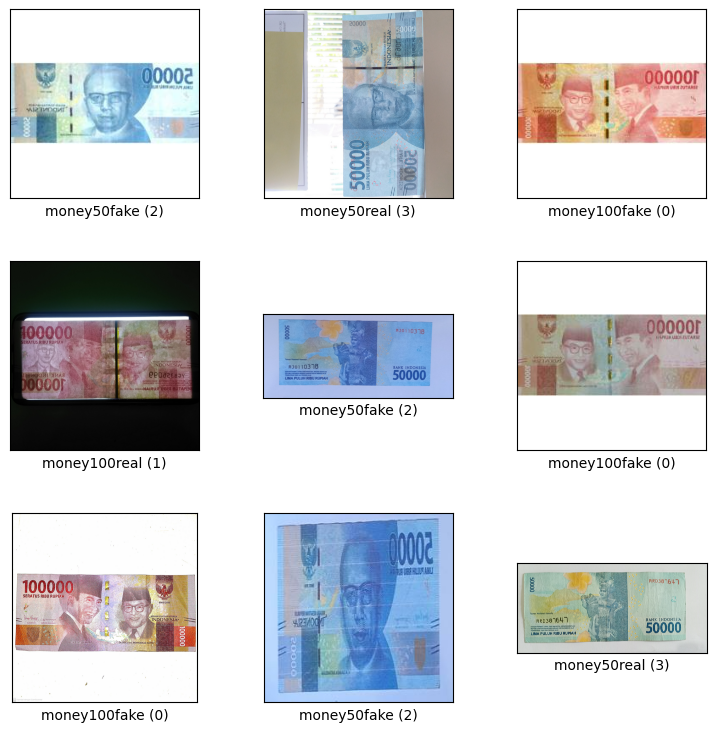

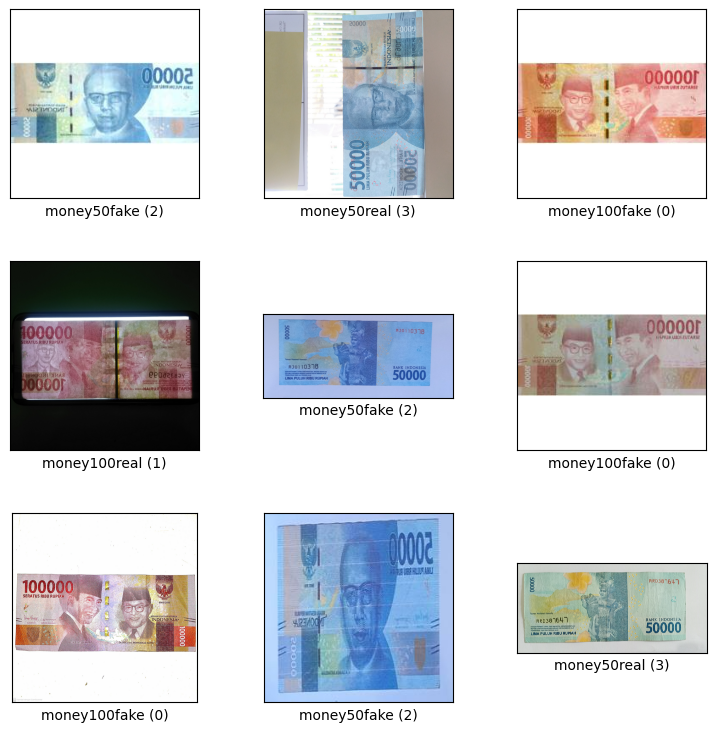

In [23]:
# Load dataset menggunakan tfds.ImageFolder
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('/content/real-v-fake/')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='training', shuffle_files=True, as_supervised=True)
tfds.show_examples(ds, builder.info)

In [24]:
def insertArray(path, array):
  for folder in os.listdir(path):
    sub_path=path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        array.append(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

train_path=TRAINING_DIR
test_path=VALIDATION_DIR
val_path=TESTING_DIR

train_x=[]
test_x=[]
val_x=[]

insertArray(train_path, train_x)
insertArray(test_path, test_x)
insertArray(val_path, val_x)

In [25]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [26]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [28]:
# Class mode is set to sparse because the image samples are belong to exactly one class
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1824 images belonging to 4 classes.
Found 608 images belonging to 4 classes.
Found 608 images belonging to 4 classes.


In [29]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [30]:
training_set.class_indices

{'money100fake': 0, 'money100real': 1, 'money50fake': 2, 'money50real': 3}

In [32]:
train_y.shape,test_y.shape,val_y.shape

((1824,), (608,), (608,))

In [33]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [34]:
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))
mobile_net_layers.trainable = False

In [35]:
model = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(4,activation='softmax')
])

In [36]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [38]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [39]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[mc],
  batch_size=32,shuffle=True)

Epoch 1/100
56/57 [============================>.] - ETA: 0s - loss: 0.9263 - accuracy: 0.6328
Epoch 1: val_accuracy improved from -inf to 0.79605, saving model to best_model.h5
57/57 [==============================] - 18s 90ms/step - loss: 0.9180 - accuracy: 0.6365 - val_loss: 0.4725 - val_accuracy: 0.7961
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8218
Epoch 2: val_accuracy improved from 0.79605 to 0.80428, saving model to best_model.h5
57/57 [==============================] - 4s 65ms/step - loss: 0.4419 - accuracy: 0.8218 - val_loss: 0.3811 - val_accuracy: 0.8043
Epoch 3/100
56/57 [============================>.] - ETA: 0s - loss: 0.3512 - accuracy: 0.8504
Epoch 3: val_accuracy improved from 0.80428 to 0.82237, saving model to best_model.h5
57/57 [==============================] - 3s 60ms/step - loss: 0.3539 - accuracy: 0.8487 - val_loss: 0.3233 - val_accuracy: 0.8224
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 

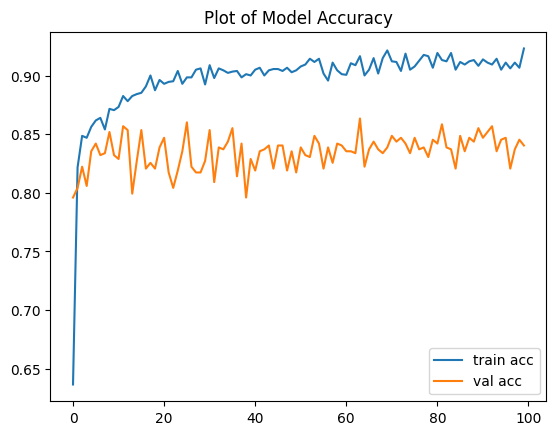

In [40]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Plot of Model Accuracy')
plt.legend()
plt.savefig('acc-rps-1.png')
plt.show()

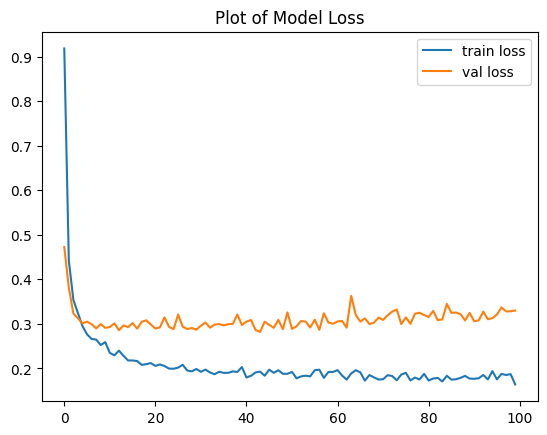

In [41]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Plot of Model Loss')
plt.legend()
plt.savefig('loss-rps-1.png')
plt.show()

In [42]:
model.evaluate(test_x,test_y,batch_size=32)

19/19 [==============================] - 1s 42ms/step - loss: 0.2594 - accuracy: 0.8553


[0.25944381952285767, 0.8552631735801697]

In [43]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

19/19 [==============================] - 2s 42ms/step


In [44]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       0.69      0.82      0.75       162
           2       0.74      0.58      0.65       142
           3       1.00      1.00      1.00       192

    accuracy                           0.86       608
   macro avg       0.86      0.85      0.85       608
weighted avg       0.86      0.86      0.85       608



In [45]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test_y, y_pred)

print(cf_matrix)

[[112   0   0   0]
 [  0 133  59   0]
 [  0  29  83   0]
 [  0   0   0 192]]


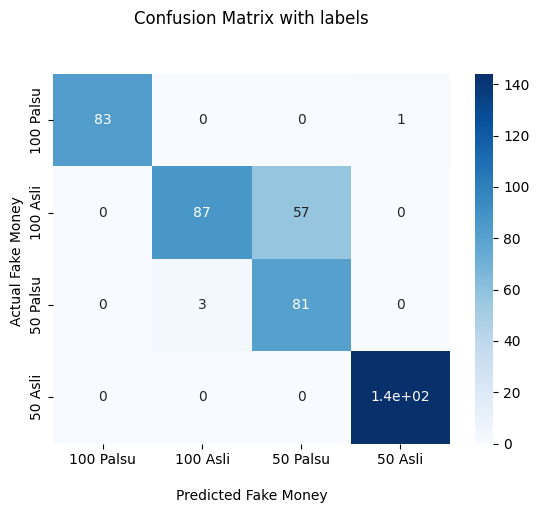

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Fake Money')
ax.set_ylabel('Actual Fake Money ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])
ax.yaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])

## Display the visualization of the Confusion Matrix.
plt.show()

# MOBILENETV2 - FULL - 70:15:15

In [49]:
# Model kedua untuk Arsitektur MobileNetV2 - Full Dataset - Split 70:15:15
root_dir = '/content/model2'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/model2' directory.

Training directory created as '/content/model2/training'.

Validation directory created as '/content/model2/validation'.

Testing directory created as '/content/model2/testing'.

Creating the subfolders for storing fake and real money images.
'/content/model2/training/money50real' and '/content/model2/training/money100real' created.
'/content/model2/training/money50fake' and '/content/model2/training/money100fake' created.
'/content/model2/validation/money50real' and '/content/model2/validation/money100real' created.
'/content/model2/validation/money50fake' and '/content/model2/validation/money100fake' created.
'/content/model2/testing/money50real' and '/content/model2/testing/money100real' created.
'/content/model2/testing/money50fake' and '/content/model2/testing/money100fake' created.


In [50]:
TRAINING_DIR = "/content/model2/training/"
VALIDATION_DIR = "/content/model2/validation/"
TESTING_DIR = "/content/model2/testing/"

In [51]:
# Define directories path

TRAINING_REAL_LIMA_DIR = os.path.join(TRAINING_DIR, "money50real/")
VALIDATION_REAL_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50real/")
TESTING_REAL_LIMA_DIR = os.path.join(TESTING_DIR, "money50real/")

TRAINING_REAL_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100real/")
VALIDATION_REAL_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100real/")
TESTING_REAL_SERATUS_DIR = os.path.join(TESTING_DIR, "money100real/")

TRAINING_FAKE_LIMA_DIR = os.path.join(TRAINING_DIR, "money50fake/")
VALIDATION_FAKE_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50fake/")
TESTING_FAKE_LIMA_DIR = os.path.join(TESTING_DIR, "money50fake/")

TRAINING_FAKE_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100fake/")
VALIDATION_FAKE_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100fake/")
TESTING_FAKE_SERATUS_DIR = os.path.join(TESTING_DIR, "money100fake/")

In [52]:
# Run split data function

# Define proportion of images used for training
split_size = .7

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(TESTING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_SERATUS_DIR):
    os.remove(file.path)

In [53]:
split_data(REAL_LIMA_SOURCE_DIR, TRAINING_REAL_LIMA_DIR, VALIDATION_REAL_LIMA_DIR, TESTING_REAL_LIMA_DIR, split_size)
split_data(REAL_SERATUS_SOURCE_DIR, TRAINING_REAL_SERATUS_DIR, VALIDATION_REAL_SERATUS_DIR, TESTING_REAL_SERATUS_DIR, split_size)
split_data(FAKE_LIMA_SOURCE_DIR, TRAINING_FAKE_LIMA_DIR, VALIDATION_FAKE_LIMA_DIR, TESTING_FAKE_LIMA_DIR, split_size)
split_data(FAKE_SERATUS_SOURCE_DIR, TRAINING_FAKE_SERATUS_DIR, VALIDATION_FAKE_SERATUS_DIR, TESTING_FAKE_SERATUS_DIR, split_size)

In [54]:
# Train Images
print("===Training Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TRAINING_REAL_LIMA_DIR)), len(os.listdir(TRAINING_REAL_SERATUS_DIR)), len(os.listdir(TRAINING_FAKE_LIMA_DIR)), len(os.listdir(TRAINING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Training Images Dataset===



,Total Images
50.000 Asli,672
100.000 Asli,672
50.000 Palsu,392
100.000 Palsu,392


In [55]:
# Validation Images
print("===Validation Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(VALIDATION_REAL_LIMA_DIR)), len(os.listdir(VALIDATION_REAL_SERATUS_DIR)), len(os.listdir(VALIDATION_FAKE_LIMA_DIR)), len(os.listdir(VALIDATION_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Validation Images Dataset===



,Total Images
50.000 Asli,144
100.000 Asli,144
50.000 Palsu,84
100.000 Palsu,84


In [56]:
# Testing Images
print("===Testing Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TESTING_REAL_LIMA_DIR)), len(os.listdir(TESTING_REAL_SERATUS_DIR)), len(os.listdir(TESTING_FAKE_LIMA_DIR)), len(os.listdir(TESTING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Testing Images Dataset===



,Total Images
50.000 Asli,144
100.000 Asli,144
50.000 Palsu,84
100.000 Palsu,84


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/content/model2/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testing': <SplitInfo num_examples=456, num_shards=1>,
        'training': <SplitInfo num_examples=2128, num_shards=1>,
        'validation': <SplitInfo num_examples=456, num_shards=1>,
    },
    citation="""""",
)


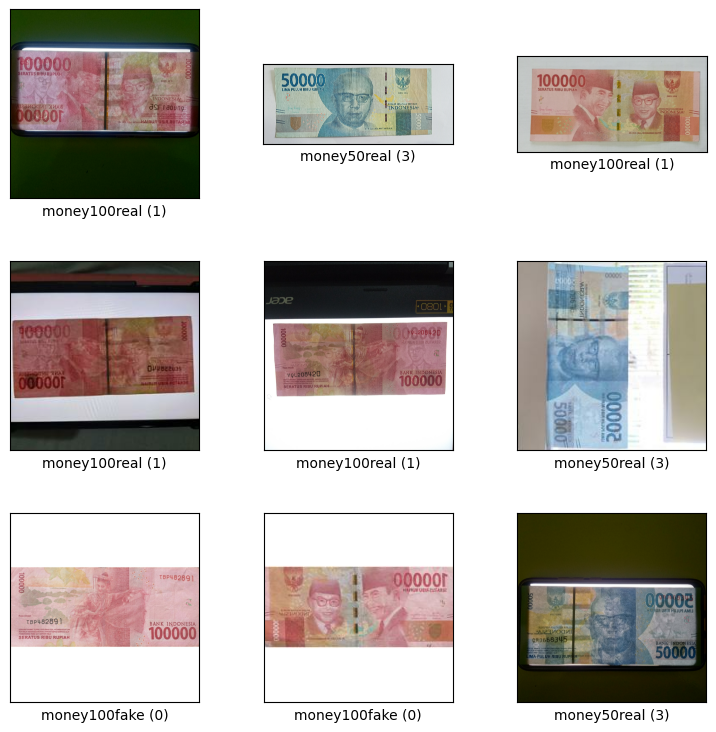

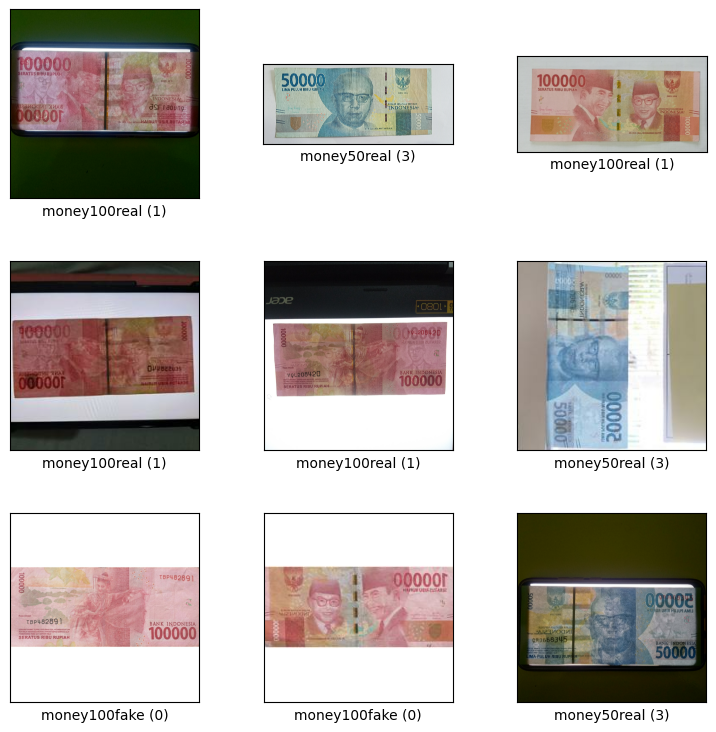

In [57]:
# Load dataset menggunakan tfds.ImageFolder
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('/content/model2/')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='training', shuffle_files=True, as_supervised=True)
tfds.show_examples(ds, builder.info)

In [58]:
train_path=TRAINING_DIR
test_path=VALIDATION_DIR
val_path=TESTING_DIR

In [59]:
train_x=[]
test_x=[]
val_x=[]

insertArray(train_path, train_x)
insertArray(test_path, test_x)
insertArray(val_path, val_x)

In [60]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [61]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [63]:
# Class mode is set to sparse because the image samples are belong to exactly one class
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 2128 images belonging to 4 classes.
Found 456 images belonging to 4 classes.
Found 456 images belonging to 4 classes.


In [64]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [65]:
training_set.class_indices

{'money100fake': 0, 'money100real': 1, 'money50fake': 2, 'money50real': 3}

In [66]:
train_y.shape,test_y.shape,val_y.shape

((2128,), (456,), (456,))

In [67]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [68]:
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))
mobile_net_layers.trainable = False

In [69]:
model = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(4,activation='softmax')
])

In [70]:
# view the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [71]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [72]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [73]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[mc],
  batch_size=32,shuffle=True)

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 1.2177 - accuracy: 0.4864
Epoch 1: val_accuracy improved from -inf to 0.74561, saving model to best_model.h5
67/67 [==============================] - 11s 81ms/step - loss: 1.2177 - accuracy: 0.4864 - val_loss: 0.7138 - val_accuracy: 0.7456
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.7025
Epoch 2: val_accuracy improved from 0.74561 to 0.82018, saving model to best_model.h5
67/67 [==============================] - 3s 47ms/step - loss: 0.7340 - accuracy: 0.7025 - val_loss: 0.5203 - val_accuracy: 0.8202
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.7711
Epoch 3: val_accuracy improved from 0.82018 to 0.83991, saving model to best_model.h5
67/67 [==============================] - 3s 48ms/step - loss: 0.5698 - accuracy: 0.7711 - val_loss: 0.4566 - val_accuracy: 0.8399
Epoch 4/100
67/67 [==============================] - ETA: 0s - loss: 

In [74]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

15/15 [==============================] - 1s 35ms/step


In [75]:
model.evaluate(test_x,test_y,batch_size=32)

15/15 [==============================] - 1s 33ms/step - loss: 0.2903 - accuracy: 0.8662


[0.29029572010040283, 0.8662280440330505]

In [76]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        83
           1       0.60      0.97      0.74        90
           2       0.96      0.59      0.73       138
           3       1.00      0.99      1.00       145

    accuracy                           0.87       456
   macro avg       0.89      0.89      0.87       456
weighted avg       0.91      0.87      0.87       456



In [77]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test_y, y_pred)

print(cf_matrix)

[[ 83   0   0   1]
 [  0  87  57   0]
 [  0   3  81   0]
 [  0   0   0 144]]


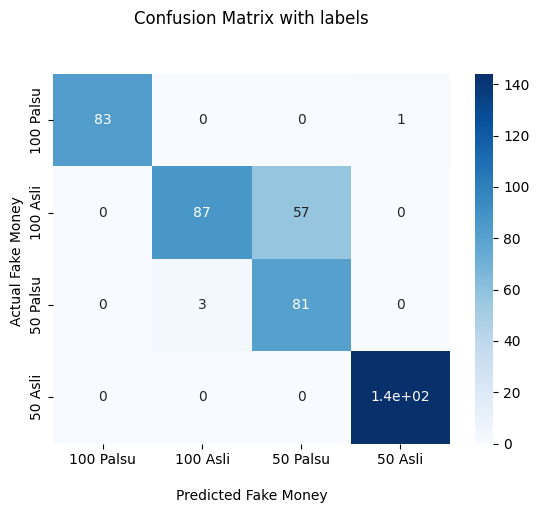

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Fake Money')
ax.set_ylabel('Actual Fake Money ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])
ax.yaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])

## Display the visualization of the Confusion Matrix.
plt.show()

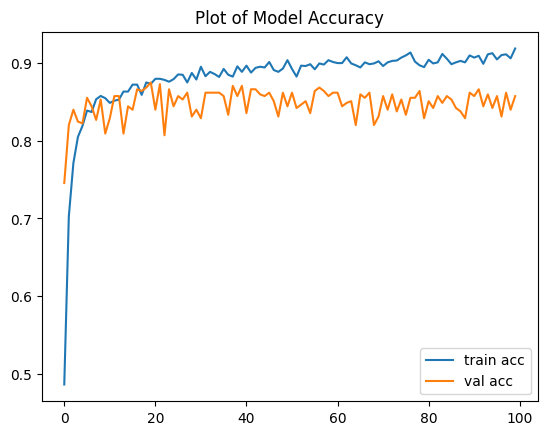

In [79]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Plot of Model Accuracy')
plt.legend()
plt.savefig('mobilenet-full-2-acc.png')
plt.show()

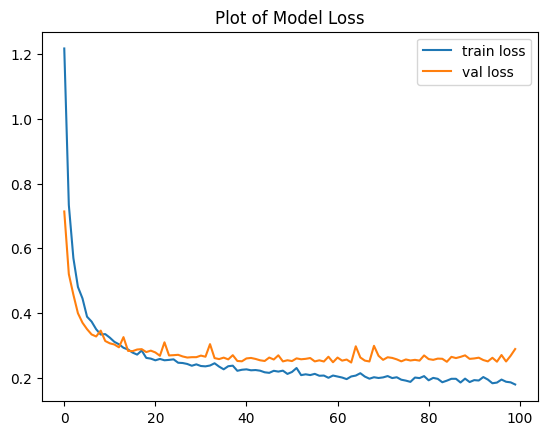

In [80]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Plot of Model Loss')
plt.legend()
plt.savefig('mobilenet-full-2-loss.png')
plt.show()

# MobileNetv2 - Full - 80:10:10

In [86]:
# Model kedua untuk Arsitektur MobileNetV2 - Full Dataset - Split 80:10:10
root_dir = '/content/model3'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/content/model3' directory.

Training directory created as '/content/model3/training'.

Validation directory created as '/content/model3/validation'.

Testing directory created as '/content/model3/testing'.

Creating the subfolders for storing fake and real money images.
'/content/model3/training/money50real' and '/content/model3/training/money100real' created.
'/content/model3/training/money50fake' and '/content/model3/training/money100fake' created.
'/content/model3/validation/money50real' and '/content/model3/validation/money100real' created.
'/content/model3/validation/money50fake' and '/content/model3/validation/money100fake' created.
'/content/model3/testing/money50real' and '/content/model3/testing/money100real' created.
'/content/model3/testing/money50fake' and '/content/model3/testing/money100fake' created.


In [87]:
TRAINING_DIR = "/content/model3/training/"
VALIDATION_DIR = "/content/model3/validation/"
TESTING_DIR = "/content/model3/testing/"

In [88]:
# Define directories path

TRAINING_REAL_LIMA_DIR = os.path.join(TRAINING_DIR, "money50real/")
VALIDATION_REAL_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50real/")
TESTING_REAL_LIMA_DIR = os.path.join(TESTING_DIR, "money50real/")

TRAINING_REAL_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100real/")
VALIDATION_REAL_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100real/")
TESTING_REAL_SERATUS_DIR = os.path.join(TESTING_DIR, "money100real/")

TRAINING_FAKE_LIMA_DIR = os.path.join(TRAINING_DIR, "money50fake/")
VALIDATION_FAKE_LIMA_DIR = os.path.join(VALIDATION_DIR, "money50fake/")
TESTING_FAKE_LIMA_DIR = os.path.join(TESTING_DIR, "money50fake/")

TRAINING_FAKE_SERATUS_DIR = os.path.join(TRAINING_DIR, "money100fake/")
VALIDATION_FAKE_SERATUS_DIR = os.path.join(VALIDATION_DIR, "money100fake/")
TESTING_FAKE_SERATUS_DIR = os.path.join(TESTING_DIR, "money100fake/")

In [89]:
# Run split data function

# Define proportion of images used for training
split_size = .8

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FAKE_SERATUS_DIR):
    os.remove(file.path)

if len(os.listdir(TESTING_REAL_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_REAL_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_REAL_SERATUS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_LIMA_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_LIMA_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FAKE_SERATUS_DIR)) > 0:
  for file in os.scandir(TESTING_FAKE_SERATUS_DIR):
    os.remove(file.path)

In [90]:
split_data(REAL_LIMA_SOURCE_DIR, TRAINING_REAL_LIMA_DIR, VALIDATION_REAL_LIMA_DIR, TESTING_REAL_LIMA_DIR, split_size)
split_data(REAL_SERATUS_SOURCE_DIR, TRAINING_REAL_SERATUS_DIR, VALIDATION_REAL_SERATUS_DIR, TESTING_REAL_SERATUS_DIR, split_size)
split_data(FAKE_LIMA_SOURCE_DIR, TRAINING_FAKE_LIMA_DIR, VALIDATION_FAKE_LIMA_DIR, TESTING_FAKE_LIMA_DIR, split_size)
split_data(FAKE_SERATUS_SOURCE_DIR, TRAINING_FAKE_SERATUS_DIR, VALIDATION_FAKE_SERATUS_DIR, TESTING_FAKE_SERATUS_DIR, split_size)

In [91]:
# Train Images
print("===Training Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TRAINING_REAL_LIMA_DIR)), len(os.listdir(TRAINING_REAL_SERATUS_DIR)), len(os.listdir(TRAINING_FAKE_LIMA_DIR)), len(os.listdir(TRAINING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Training Images Dataset===



,Total Images
50.000 Asli,768
100.000 Asli,768
50.000 Palsu,448
100.000 Palsu,448


In [92]:
# Validation Images
print("===Validation Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(VALIDATION_REAL_LIMA_DIR)), len(os.listdir(VALIDATION_REAL_SERATUS_DIR)), len(os.listdir(VALIDATION_FAKE_LIMA_DIR)), len(os.listdir(VALIDATION_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Validation Images Dataset===



,Total Images
50.000 Asli,96
100.000 Asli,96
50.000 Palsu,56
100.000 Palsu,56


In [93]:
# Testing Images
print("===Testing Images Dataset===\n")
pd.DataFrame(data=[len(os.listdir(TESTING_REAL_LIMA_DIR)), len(os.listdir(TESTING_REAL_SERATUS_DIR)), len(os.listdir(TESTING_FAKE_LIMA_DIR)), len(os.listdir(TESTING_FAKE_SERATUS_DIR))], index=['50.000 Asli', '100.000 Asli', '50.000 Palsu', '100.000 Palsu'], columns=['Total Images'])

===Testing Images Dataset===



,Total Images
50.000 Asli,96
100.000 Asli,96
50.000 Palsu,56
100.000 Palsu,56


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/content/model3/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testing': <SplitInfo num_examples=304, num_shards=1>,
        'training': <SplitInfo num_examples=2432, num_shards=1>,
        'validation': <SplitInfo num_examples=304, num_shards=1>,
    },
    citation="""""",
)


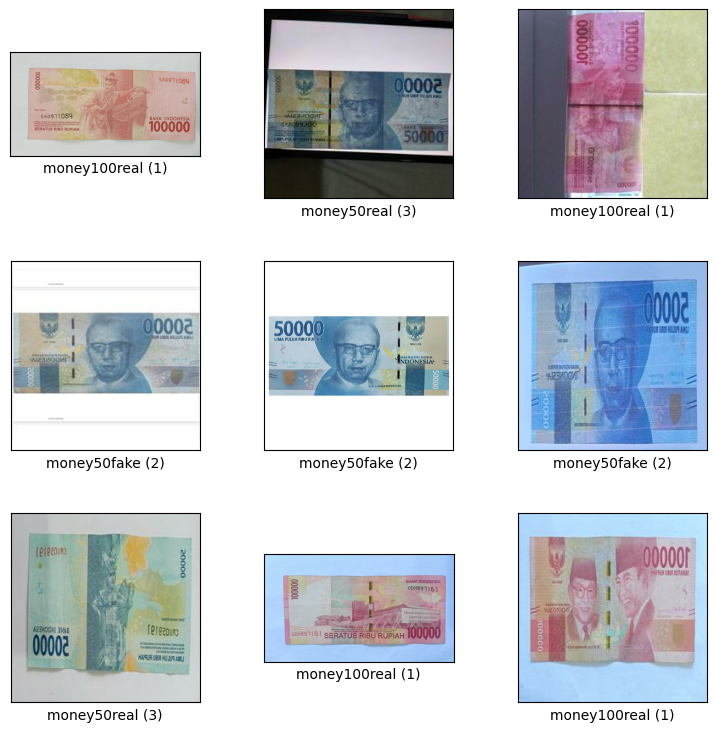

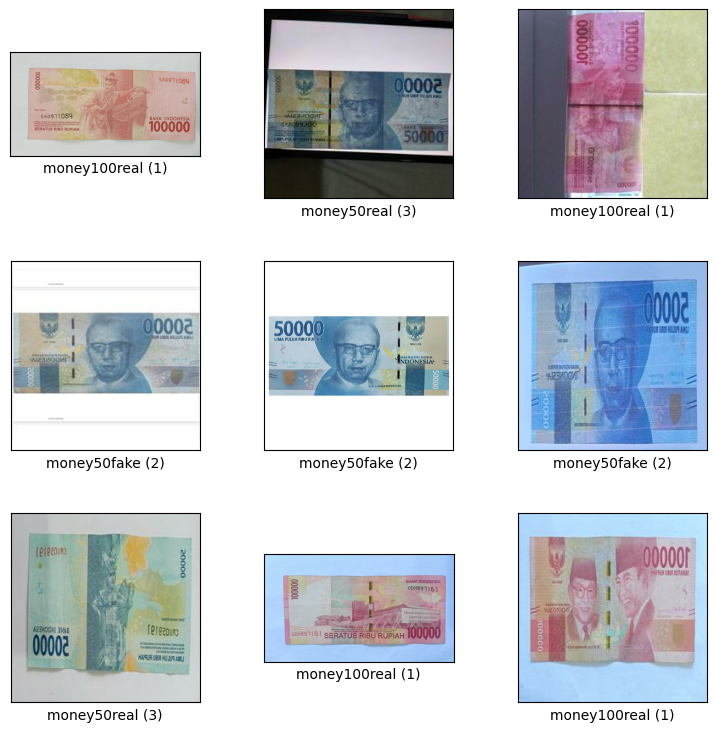

In [94]:
# Load dataset menggunakan tfds.ImageFolder
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('/content/model3/')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='training', shuffle_files=True, as_supervised=True)
tfds.show_examples(ds, builder.info)

In [95]:
train_path=TRAINING_DIR
test_path=VALIDATION_DIR
val_path=TESTING_DIR

In [96]:
train_x=[]
test_x=[]
val_x=[]

insertArray(train_path, train_x)
insertArray(test_path, test_x)
insertArray(val_path, val_x)

In [97]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)

In [98]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [99]:
# Class mode is set to sparse because the image samples are belong to exactly one class
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 2432 images belonging to 4 classes.
Found 304 images belonging to 4 classes.
Found 304 images belonging to 4 classes.


In [100]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [101]:
training_set.class_indices

{'money100fake': 0, 'money100real': 1, 'money50fake': 2, 'money50real': 3}

In [102]:
train_y.shape,test_y.shape,val_y.shape

((2432,), (304,), (304,))

In [103]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [104]:
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))
mobile_net_layers.trainable = False

In [105]:
model = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(4,activation='softmax')
])

In [106]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [107]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[mc],
  batch_size=32,shuffle=True)

Epoch 1/100
75/76 [============================>.] - ETA: 0s - loss: 1.0538 - accuracy: 0.5333
Epoch 1: val_accuracy did not improve from 0.87500
76/76 [==============================] - 7s 54ms/step - loss: 1.0484 - accuracy: 0.5362 - val_loss: 0.6715 - val_accuracy: 0.7336
Epoch 2/100
75/76 [============================>.] - ETA: 0s - loss: 0.6405 - accuracy: 0.7354
Epoch 2: val_accuracy did not improve from 0.87500
76/76 [==============================] - 3s 38ms/step - loss: 0.6391 - accuracy: 0.7364 - val_loss: 0.4951 - val_accuracy: 0.8125
Epoch 3/100
75/76 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.7892
Epoch 3: val_accuracy did not improve from 0.87500
76/76 [==============================] - 3s 37ms/step - loss: 0.5191 - accuracy: 0.7891 - val_loss: 0.4191 - val_accuracy: 0.8322
Epoch 4/100
75/76 [============================>.] - ETA: 0s - loss: 0.4452 - accuracy: 0.8171
Epoch 4: val_accuracy did not improve from 0.87500
76/76 [===================

In [108]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

10/10 [==============================] - 1s 37ms/step


In [109]:
model.evaluate(test_x,test_y,batch_size=32)

10/10 [==============================] - 0s 34ms/step - loss: 0.2839 - accuracy: 0.8191


[0.2838999032974243, 0.8190789222717285]

In [110]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       0.82      0.68      0.74       117
           2       0.32      0.51      0.40        35
           3       1.00      1.00      1.00        96

    accuracy                           0.82       304
   macro avg       0.79      0.80      0.78       304
weighted avg       0.85      0.82      0.83       304



In [111]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test_y, y_pred)

print(cf_matrix)

[[56  0  0  0]
 [ 0 79 17  0]
 [ 0 38 18  0]
 [ 0  0  0 96]]


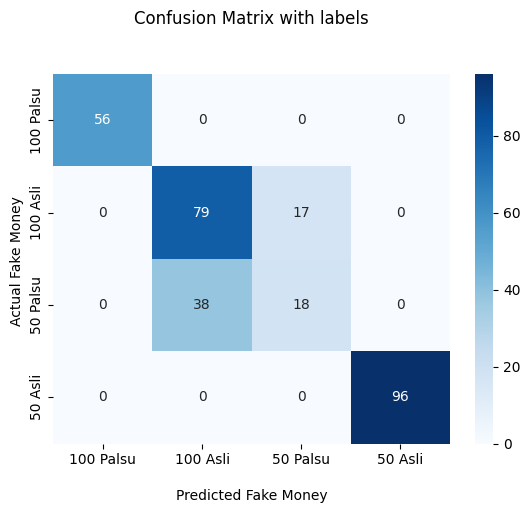

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Fake Money')
ax.set_ylabel('Actual Fake Money ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])
ax.yaxis.set_ticklabels(['100 Palsu','100 Asli', '50 Palsu', '50 Asli'])

## Display the visualization of the Confusion Matrix.
plt.show()

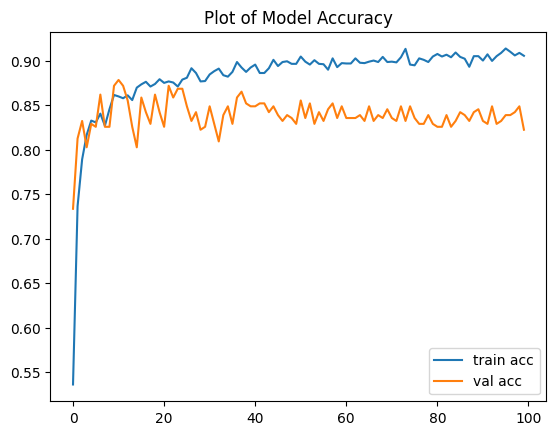

In [113]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Plot of Model Accuracy')
plt.legend()
plt.savefig('mobilenet-full-3-acc.png')
plt.show()

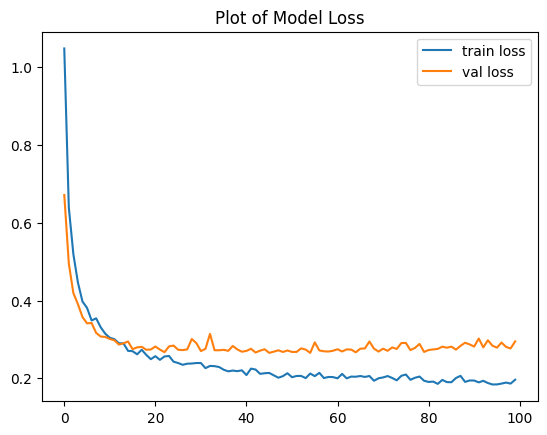

In [114]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Plot of Model Loss')
plt.legend()
plt.savefig('mobilenet-full-2-loss.png')
plt.show()

# Test Upload

In [115]:
# new_size = (224,224)
# uploaded = files.upload().resize(new_size)


# for file_upload in uploaded:
#   path = file_upload
#   img = image.load_img(path, target_size=(150,150))
#   imgplot = plt.imshow(img)
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=16)
#   print('=== Hasil Prediksi ===')

#   if classes[0][0] == 1:
#     print('Ini adalah gambar: Paper')
#   elif classes[0][1] == 1:
#     print('Ini adalah gambar: Rock')
#   elif classes[0][2] == 1:
#     print('Ini adalah gambar: Scissor')
#   else:
#     print('Ini adalah gambar: Jancok')